In [1]:
from pandas import DataFrame as DF, Series
import numpy as np
from pymongo import MongoClient

# single machine setup (mongo is running here localy)
MY_DATABASE_LINK = 'mongodb://192.168.1.191:27020/' #'mongodb://192.168.100.57:27020/'
# multiple mechine setup (mongo is running on another machine)
#MY_DATABASE_LINK = 'mongodb://192.168.43.78:27020/'

class DatabaseConnect:
    DB_LINK = MY_DATABASE_LINK

    class Base:
        client = None
        @classmethod
        def connect(cls, databaseName):
            cls.client = MongoClient(DatabaseConnect.DB_LINK)
            # Access the database
            return cls.client[databaseName]

        @classmethod
        def close(cls):
            if cls.client:
                cls.client.close()
                cls.client = None

        @classmethod
        def getCollection(cls, collectionName):
            return cls.client[collectionName]


    class mini_database(Base):
        @classmethod
        def projects(cls):
            return cls.connect('mini_database')['projects']
        @classmethod
        def users(cls):
            return cls.connect('mini_database')['users']

projectsCollection = DatabaseConnect.mini_database.projects()
print(projectsCollection)


Collection(Database(MongoClient(host=['192.168.1.191:27020'], document_class=dict, tz_aware=False, connect=True), 'mini_database'), 'projects')


In [2]:
def getProjectsStars() -> list:
    cursor = projectsCollection.find()
    stars = []

    for proj in cursor:
        try:
            stars.append(proj["stars"])
        except KeyError:
            continue

    return np.array(stars)

def percentileThreshold(stars, percentile=50):
    return np.percentile(stars, percentile)

starsArray = getProjectsStars()
starsThreshold = percentileThreshold(starsArray, 75)  # Keep top 25% posts
starsThreshold

2.0

In [3]:
def collectProjectsStatistics():
    global starsThreshold
    stats = Series({
        "Total project" : 0,
        "High quality" : 0,
        "Good" : 0,
        "Sufficient" : 0,
        "Has description" : 0,
        "Has topics" : 0,
        "Avg description length" : 0
    })
    description_lengths = []
    cursor = projectsCollection.find()

    for proj in cursor:
        try:
            desc = proj["description"]
            #print(desc)
        except KeyError:
            continue
        if desc:
            stats["Has description"] += 1
            #print(type(desc))
            description_lengths.append(len(desc))
        
        if len(proj["topics"]):
            stats["Has topics"] += 1

        if desc and (len(proj["topics"]) and proj["language"]) and proj["stars"] >= starsThreshold:
            stats["High quality"] += 1
        
        if desc and (len(proj["topics"]) and proj["language"]):
            stats["Good"] += 1
        
        if desc and (len(proj["topics"]) or proj["language"]):
            stats["Sufficient"] += 1
        stats["Total project"] += 1

    stats["Avg description length"] = sum(description_lengths) / stats["Has description"]

    return stats

In [4]:
stats = collectProjectsStatistics()

/tmp/ipykernel_356/3129867531.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '69.4804533075639' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stats["Avg description length"] = sum(description_lengths) / stats["Has description"]


In [5]:
from matplotlib import pyplot as plt

In [6]:
stats.index

Index(['Total project', 'High quality', 'Good', 'Sufficient',
       'Has description', 'Has topics', 'Avg description length'],
      dtype='object')

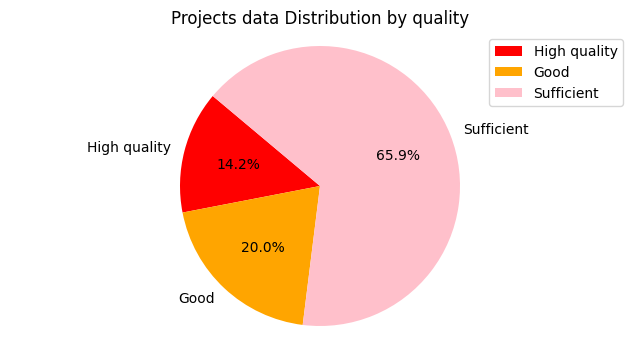

In [7]:
labels = "High quality,Good,Sufficient".split(",")
proportions = [stats[lbl] for lbl in labels]
proportions = proportions / sum(proportions) * 100 # Proportions of each category
colors = ['red', 'orange', 'pink', 'brown', 'green']
explode = (0,) * len(proportions)  # Explode the 2nd slice

# Creating the pie chart
plt.figure(figsize=(8,4))
plt.pie(proportions, labels=labels, colors=colors, autopct='%1.1f%%', explode=explode, shadow=False, startangle=140)

# Display the chart
plt.axis('equal')  # Ensures the pie is a circle
plt.title("Projects data Distribution by quality")
plt.legend()
plt.show()

In [8]:
stats

Total project             31113.000000
High quality               4258.000000
Good                       6015.000000
Sufficient                19818.000000
Has description           22766.000000
Has topics                 6719.000000
Avg description length       69.480453
dtype: float64

In [11]:
import re

def countCamelCase(camelCase):
    template = "[a-z]+[A-Z]+[a-z]*[A-Z]*[a-z]*[A-Z]*[a-z]*[A-Z]*[a-z]*"
    text = camelCase
    n = 0
    spans = []

    while found := re.search(template, text[n:]):
        spans.append((found.span()[0] + n, found.span()[1] + n))
        n += found.span()[1]

    return len(spans)

def collectProjectsCamelCaseStatistics():
    stats = Series({
        "Total project" : 0,
        "CamelCase projects" : []
    })
    description_lengths = []
    cursor = projectsCollection.find()

    for proj in cursor:
        try:
            desc = proj["description"]
            #print(desc)
        except KeyError:
            continue

        if countCamelCase(desc) > 0:
            stats["CamelCase projects"].append(proj)

        stats["Total project"] += 1

    return stats

stats = collectProjectsCamelCaseStatistics()

print(len(stats["CamelCase projects"]))
print(stats["CamelCase projects"])

4916
[{'_id': ObjectId('67cccc4cdc1555f3fdc9ad93'), 'id': 'github:DylanVann/react-native-fast-image', 'name': 'react-native-fast-image', 'description': '🚩 FastImage, performant React Native image component.', 'language': 'TypeScript', 'topics': ['cocoapod', 'glide', 'hacktoberfest', 'image', 'image-cache', 'priority', 'react-native', 'sdwebimage'], 'stars': 8264}, {'_id': ObjectId('67cccc4cdc1555f3fdc9ad98'), 'id': 'github:452MJ/react-native-fast-image', 'name': 'react-native-fast-image', 'description': '🚩 FastImage, performant React Native image component.', 'language': 'TypeScript', 'topics': [], 'stars': 0}, {'_id': ObjectId('67cccc4cdc1555f3fdc9ada1'), 'id': 'github:452MJ/jpush-react-native', 'name': 'jpush-react-native', 'description': "JPush's officially supported React Native plugin (Android & iOS). 极光推送官方支持的 React Native 插件（Android & iOS）。", 'language': 'Objective-C', 'topics': [], 'stars': 0}, {'_id': ObjectId('67cccc4cdc1555f3fdc9ada8'), 'id': 'github:452MJ/react-native-alipa